In [1]:
#library imports
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras.utils import pad_sequences
import neurokit2 as nk

In [2]:
normal_sinus_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/normal"
wpw_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/wpw"

In [3]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [4]:
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)

In [5]:
normal_sinus = import_ecg_data(normal_sinus_dir)
wpw = import_ecg_data(wpw_dir)

Starting ECG import..


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:03<00:00, 101.97it/s]


Finished!
Starting ECG import..


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:03<00:00, 91.78it/s]

Finished!


In [6]:
wpw

array([[[    0,     0,     0, ...,   -68,   -68,   -78],
        [  -19,   -19,   -19, ...,  -112,  -107,  -146],
        [  -19,   -19,   -19, ...,   -43,   -39,   -68],
        ...,
        [  -48,   -48,   -48, ...,   -39,   -39,   -34],
        [  -39,   -39,   -39, ...,   -58,   -58,   -48],
        [    9,     9,     9, ...,  -195,  -195,  -195]],

       [[  146,   146,   146, ...,   -43,   -43,   -53],
        [  244,   244,   244, ...,   -97,   -87,   -97],
        [   97,    97,    97, ...,   -53,   -43,   -43],
        ...,
        [  263,   263,   263, ...,   -63,   -63,   -63],
        [  204,   204,   204, ...,   -43,   -43,   -53],
        [  156,   156,   156, ...,   -63,   -63,   -78]],

       [[   10,    10,    10, ...,   -60,   -60,   -60],
        [   50,    50,    50, ...,   -25,   -25,   -25],
        [   40,    40,    40, ...,    35,    35,    35],
        ...,
        [  -90,   -90,   -90, ...,   -90,   -90,   -90],
        [   30,    30,    30, ...,    95,    

In [7]:
normal_sinus

array([[[  -1,   -4,    2, ...,  -25,  -23,  -32],
        [ -15,  -23,  -18, ...,  -64,  -57,  -52],
        [ -15,  -18,  -20, ...,  -39,  -34,  -20],
        ...,
        [   0,   -3,  -11, ...,  -16,  -10,   -8],
        [  -5,   -9,  -17, ...,  -27,  -21,  -23],
        [ -11,  -20,  -24, ...,  -40,  -33,  -34]],

       [[-122, -116, -104, ...,  -48,  -48,  -50],
        [ -92,  -89,  -82, ...,  -42,  -42,  -44],
        [  30,   27,   22, ...,    6,    6,    6],
        ...,
        [-123, -109,  -84, ...,  -79,  -81,  -82],
        [-155, -155, -147, ...,  -83,  -85,  -87],
        [-132, -137, -133, ..., -102, -103, -105]],

       [[  14,   12,   13, ...,  -15,  -16,  -15],
        [  -2,   -3,   -1, ..., -111, -113, -114],
        [ -15,  -14,  -13, ...,  -95,  -96,  -98],
        ...,
        [ -79,  -82,  -86, ...,    0,    1,    2],
        [ -39,  -42,  -45, ...,   21,   22,   22],
        [-156, -155, -154, ...,  112,  115,  116]],

       ...,

       [[ -11,   -7,   -

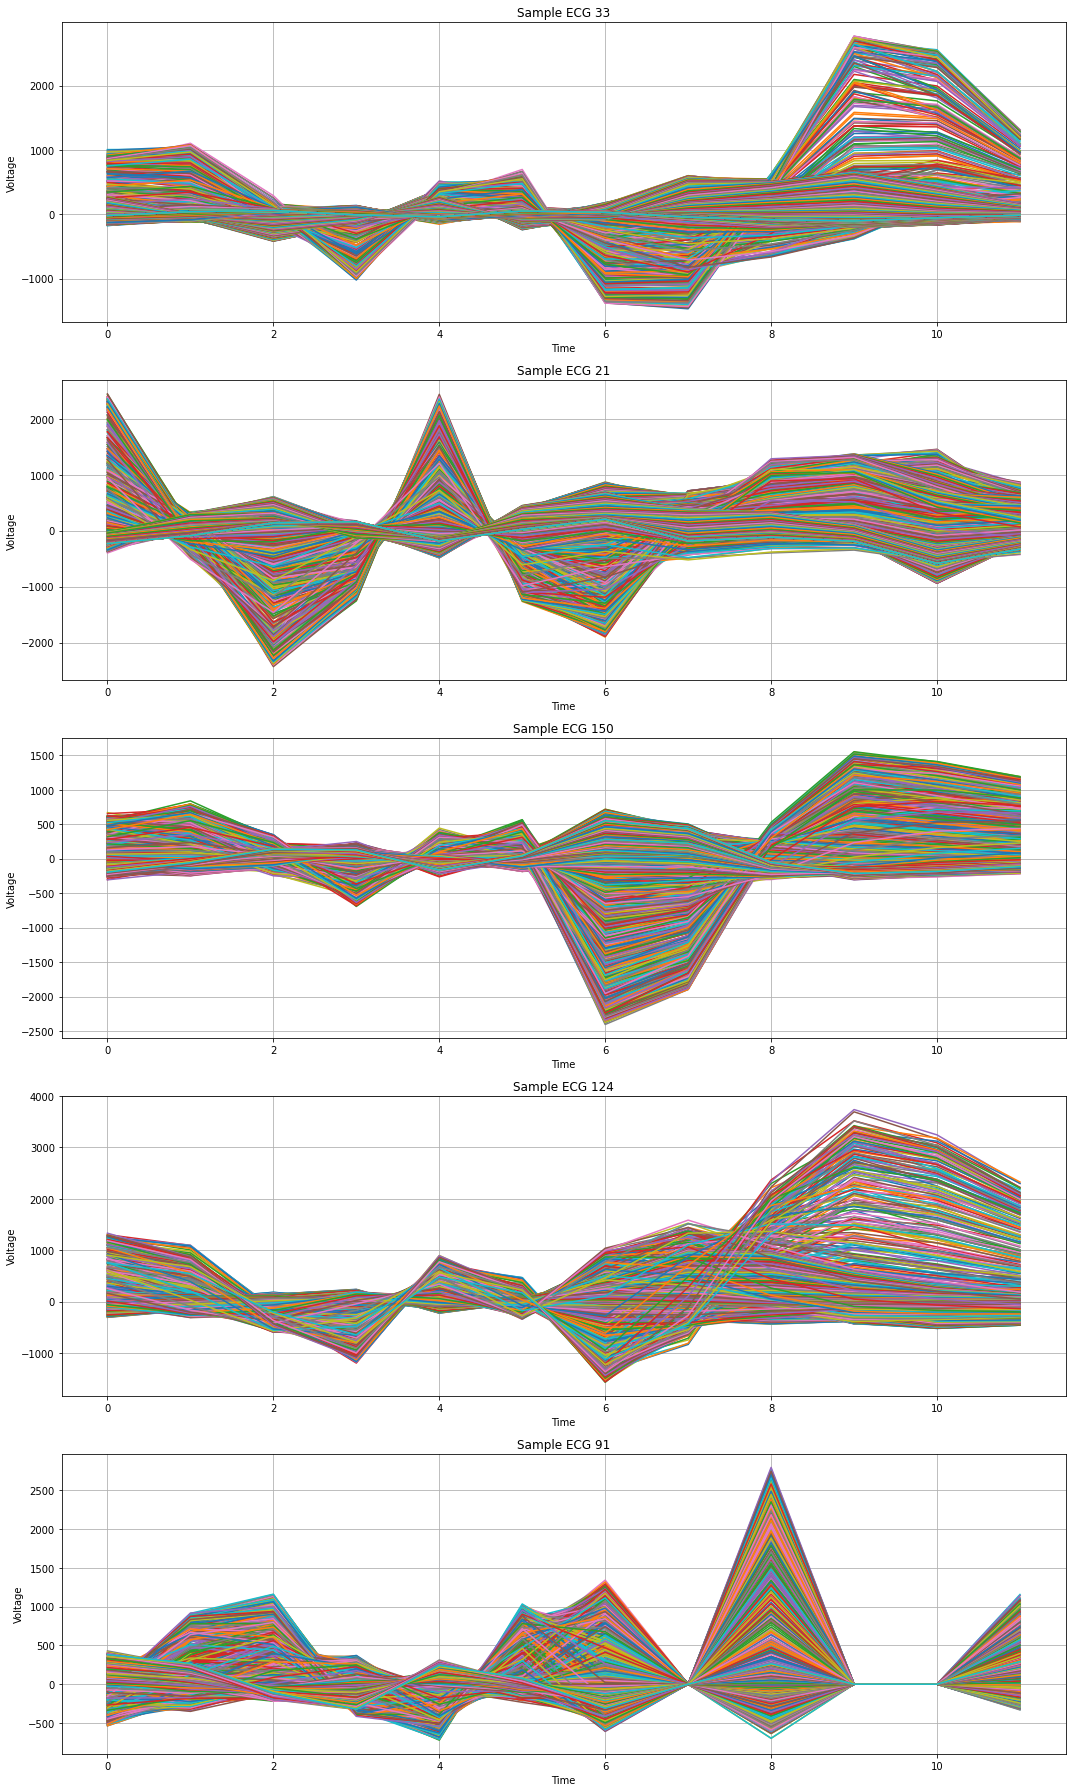

In [8]:
num_samples = 5
sample_indices = np.random.choice(len(wpw), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(wpw[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()

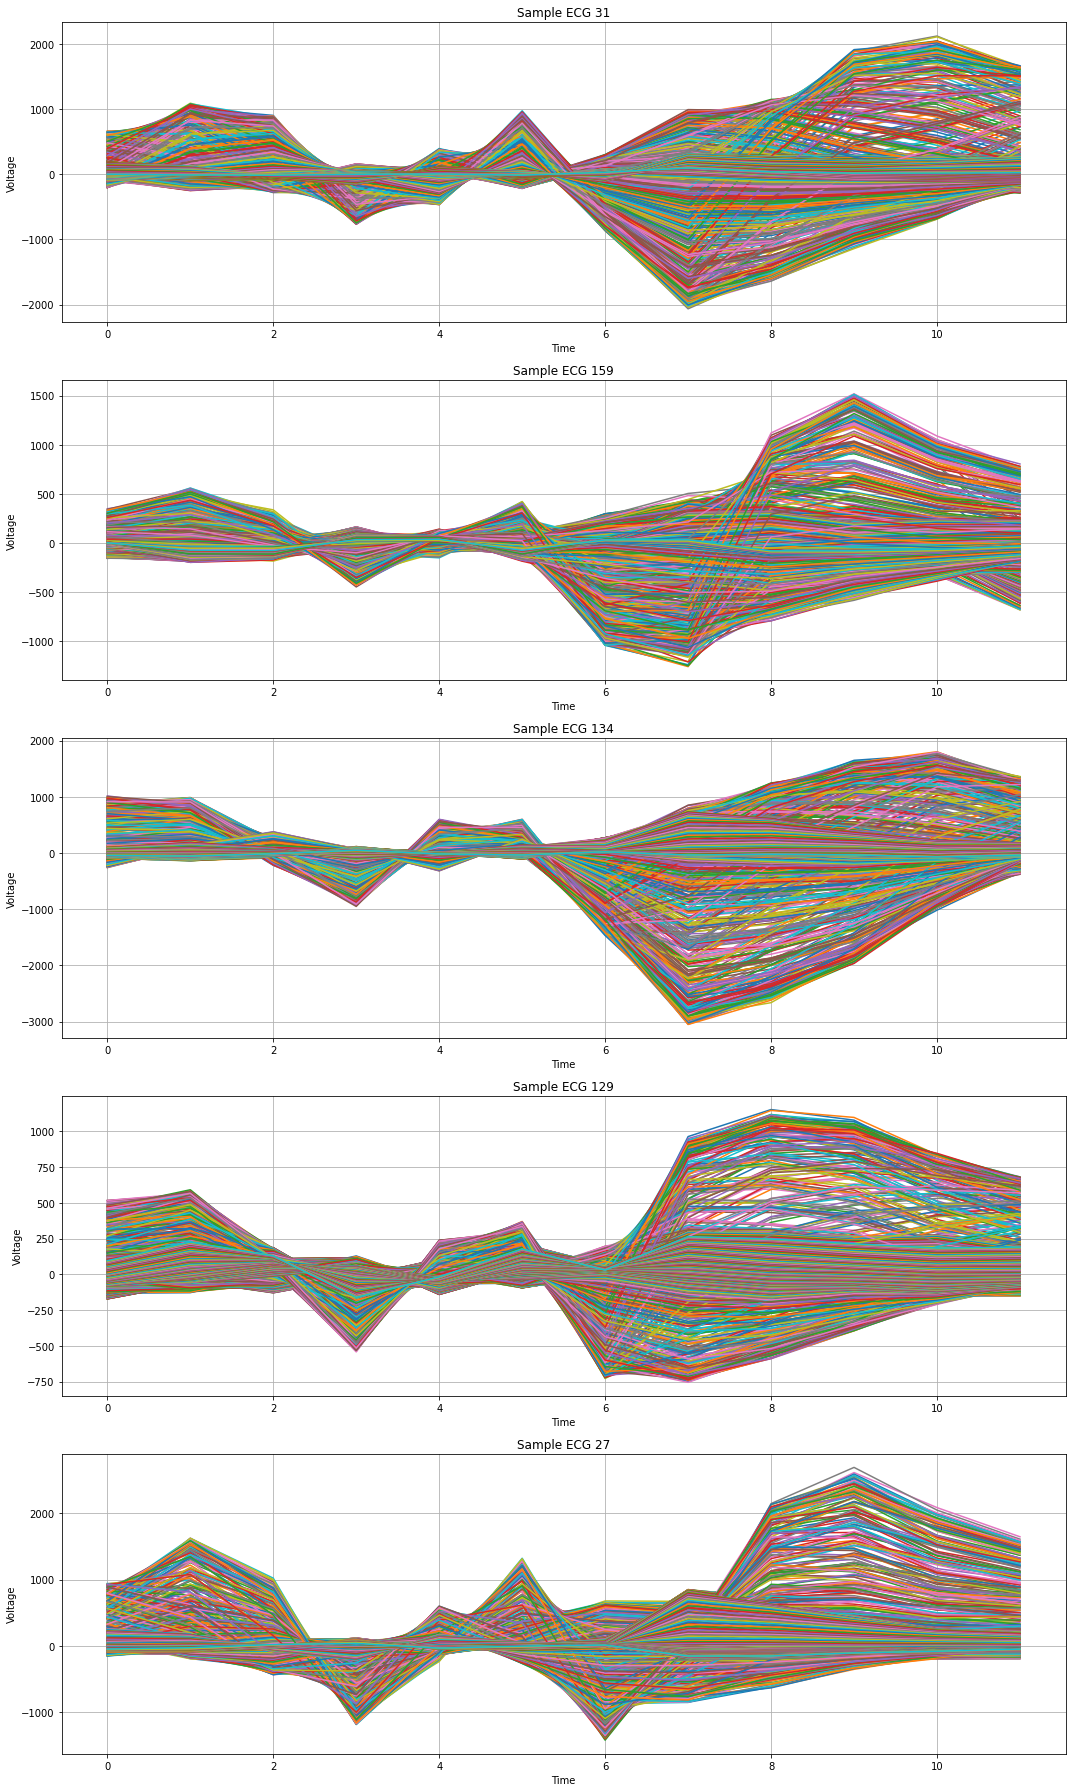

In [9]:
num_samples = 5
sample_indices = np.random.choice(len(normal_sinus), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(normal_sinus[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def resample_beats(beats):
    rsmp_beats=[]
    for i in beats:
        i = np.asarray(i)
        f = signal.resample(i, 250)
        rsmp_beats.append(f)
    rsmp_beats = np.asarray(rsmp_beats)
    return rsmp_beats
def median_beat(beat_dict):
    beats = []
    for i in beat_dict.values():
        beats.append(i['Signal'])
    beats = np.asarray(beats)
    rsmp_beats = resample_beats(beats)
    med_beat = np.median(rsmp_beats,axis=0)
    return med_beat

In [11]:
def remove_nans(ecg_arr):
    new_arr = []
    for i in tqdm(ecg_arr):
        twelve_lead = []
        for j in i:
            if j[0] != j[0]:
                j = np.ones(250)
            twelve_lead.append(j)
        new_arr.append(twelve_lead)
    new_arr = np.asarray(new_arr)
    return new_arr

In [12]:
new_norm = remove_nans(normal_sinus)
new_wpw = remove_nans(wpw)

100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 53341.44it/s]


In [13]:
new_norm

array([[[  -1,   -4,    2, ...,  -25,  -23,  -32],
        [ -15,  -23,  -18, ...,  -64,  -57,  -52],
        [ -15,  -18,  -20, ...,  -39,  -34,  -20],
        ...,
        [   0,   -3,  -11, ...,  -16,  -10,   -8],
        [  -5,   -9,  -17, ...,  -27,  -21,  -23],
        [ -11,  -20,  -24, ...,  -40,  -33,  -34]],

       [[-122, -116, -104, ...,  -48,  -48,  -50],
        [ -92,  -89,  -82, ...,  -42,  -42,  -44],
        [  30,   27,   22, ...,    6,    6,    6],
        ...,
        [-123, -109,  -84, ...,  -79,  -81,  -82],
        [-155, -155, -147, ...,  -83,  -85,  -87],
        [-132, -137, -133, ..., -102, -103, -105]],

       [[  14,   12,   13, ...,  -15,  -16,  -15],
        [  -2,   -3,   -1, ..., -111, -113, -114],
        [ -15,  -14,  -13, ...,  -95,  -96,  -98],
        ...,
        [ -79,  -82,  -86, ...,    0,    1,    2],
        [ -39,  -42,  -45, ...,   21,   22,   22],
        [-156, -155, -154, ...,  112,  115,  116]],

       ...,

       [[ -11,   -7,   -

In [14]:
new_wpw

array([[[    0,     0,     0, ...,   -68,   -68,   -78],
        [  -19,   -19,   -19, ...,  -112,  -107,  -146],
        [  -19,   -19,   -19, ...,   -43,   -39,   -68],
        ...,
        [  -48,   -48,   -48, ...,   -39,   -39,   -34],
        [  -39,   -39,   -39, ...,   -58,   -58,   -48],
        [    9,     9,     9, ...,  -195,  -195,  -195]],

       [[  146,   146,   146, ...,   -43,   -43,   -53],
        [  244,   244,   244, ...,   -97,   -87,   -97],
        [   97,    97,    97, ...,   -53,   -43,   -43],
        ...,
        [  263,   263,   263, ...,   -63,   -63,   -63],
        [  204,   204,   204, ...,   -43,   -43,   -53],
        [  156,   156,   156, ...,   -63,   -63,   -78]],

       [[   10,    10,    10, ...,   -60,   -60,   -60],
        [   50,    50,    50, ...,   -25,   -25,   -25],
        [   40,    40,    40, ...,    35,    35,    35],
        ...,
        [  -90,   -90,   -90, ...,   -90,   -90,   -90],
        [   30,    30,    30, ...,    95,    

In [15]:
def remove_some_ecgs(ecg_arr):
    delete_list = []
    for i in tqdm(range(len(ecg_arr))):
        if np.all(ecg_arr[i].T[0]==1):
            delete_list.append(i)
    ecg_arr = np.delete(ecg_arr,delete_list,axis=0)
    return ecg_arr

In [16]:
clean_wpw = remove_some_ecgs(new_wpw)
clean_norm = remove_some_ecgs(new_norm)

100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 80091.73it/s]


In [17]:
clean_wpw

array([[[    0,     0,     0, ...,   -68,   -68,   -78],
        [  -19,   -19,   -19, ...,  -112,  -107,  -146],
        [  -19,   -19,   -19, ...,   -43,   -39,   -68],
        ...,
        [  -48,   -48,   -48, ...,   -39,   -39,   -34],
        [  -39,   -39,   -39, ...,   -58,   -58,   -48],
        [    9,     9,     9, ...,  -195,  -195,  -195]],

       [[  146,   146,   146, ...,   -43,   -43,   -53],
        [  244,   244,   244, ...,   -97,   -87,   -97],
        [   97,    97,    97, ...,   -53,   -43,   -43],
        ...,
        [  263,   263,   263, ...,   -63,   -63,   -63],
        [  204,   204,   204, ...,   -43,   -43,   -53],
        [  156,   156,   156, ...,   -63,   -63,   -78]],

       [[   10,    10,    10, ...,   -60,   -60,   -60],
        [   50,    50,    50, ...,   -25,   -25,   -25],
        [   40,    40,    40, ...,    35,    35,    35],
        ...,
        [  -90,   -90,   -90, ...,   -90,   -90,   -90],
        [   30,    30,    30, ...,    95,    

In [18]:
clean_norm

array([[[  -1,   -4,    2, ...,  -25,  -23,  -32],
        [ -15,  -23,  -18, ...,  -64,  -57,  -52],
        [ -15,  -18,  -20, ...,  -39,  -34,  -20],
        ...,
        [   0,   -3,  -11, ...,  -16,  -10,   -8],
        [  -5,   -9,  -17, ...,  -27,  -21,  -23],
        [ -11,  -20,  -24, ...,  -40,  -33,  -34]],

       [[-122, -116, -104, ...,  -48,  -48,  -50],
        [ -92,  -89,  -82, ...,  -42,  -42,  -44],
        [  30,   27,   22, ...,    6,    6,    6],
        ...,
        [-123, -109,  -84, ...,  -79,  -81,  -82],
        [-155, -155, -147, ...,  -83,  -85,  -87],
        [-132, -137, -133, ..., -102, -103, -105]],

       [[  14,   12,   13, ...,  -15,  -16,  -15],
        [  -2,   -3,   -1, ..., -111, -113, -114],
        [ -15,  -14,  -13, ...,  -95,  -96,  -98],
        ...,
        [ -79,  -82,  -86, ...,    0,    1,    2],
        [ -39,  -42,  -45, ...,   21,   22,   22],
        [-156, -155, -154, ...,  112,  115,  116]],

       ...,

       [[ -11,   -7,   -

In [19]:
clean_wpw = np.moveaxis(clean_wpw, 1, -1)
clean_norm = np.moveaxis(clean_norm, 1, -1)

In [20]:
clean_wpw

array([[[    0,   -19,   -19, ...,   -48,   -39,     9],
        [    0,   -19,   -19, ...,   -48,   -39,     9],
        [    0,   -19,   -19, ...,   -48,   -39,     9],
        ...,
        [  -68,  -112,   -43, ...,   -39,   -58,  -195],
        [  -68,  -107,   -39, ...,   -39,   -58,  -195],
        [  -78,  -146,   -68, ...,   -34,   -48,  -195]],

       [[  146,   244,    97, ...,   263,   204,   156],
        [  146,   244,    97, ...,   263,   204,   156],
        [  146,   244,    97, ...,   263,   204,   156],
        ...,
        [  -43,   -97,   -53, ...,   -63,   -43,   -63],
        [  -43,   -87,   -43, ...,   -63,   -43,   -63],
        [  -53,   -97,   -43, ...,   -63,   -53,   -78]],

       [[   10,    50,    40, ...,   -90,    30,    50],
        [   10,    50,    40, ...,   -90,    30,    50],
        [   10,    50,    40, ...,   -90,    30,    50],
        ...,
        [  -60,   -25,    35, ...,   -90,    95,  -270],
        [  -60,   -25,    35, ...,   -90,    

In [21]:
clean_norm

array([[[  -1,  -15,  -15, ...,    0,   -5,  -11],
        [  -4,  -23,  -18, ...,   -3,   -9,  -20],
        [   2,  -18,  -20, ...,  -11,  -17,  -24],
        ...,
        [ -25,  -64,  -39, ...,  -16,  -27,  -40],
        [ -23,  -57,  -34, ...,  -10,  -21,  -33],
        [ -32,  -52,  -20, ...,   -8,  -23,  -34]],

       [[-122,  -92,   30, ..., -123, -155, -132],
        [-116,  -89,   27, ..., -109, -155, -137],
        [-104,  -82,   22, ...,  -84, -147, -133],
        ...,
        [ -48,  -42,    6, ...,  -79,  -83, -102],
        [ -48,  -42,    6, ...,  -81,  -85, -103],
        [ -50,  -44,    6, ...,  -82,  -87, -105]],

       [[  14,   -2,  -15, ...,  -79,  -39, -156],
        [  12,   -3,  -14, ...,  -82,  -42, -155],
        [  13,   -1,  -13, ...,  -86,  -45, -154],
        ...,
        [ -15, -111,  -95, ...,    0,   21,  112],
        [ -16, -113,  -96, ...,    1,   22,  115],
        [ -15, -114,  -98, ...,    2,   22,  116]],

       ...,

       [[ -11,  -57,  -4

In [22]:
norm_train = clean_norm[:-30]
norm_val = clean_norm[-30:]

In [23]:
norm_train

array([[[  -1,  -15,  -15, ...,    0,   -5,  -11],
        [  -4,  -23,  -18, ...,   -3,   -9,  -20],
        [   2,  -18,  -20, ...,  -11,  -17,  -24],
        ...,
        [ -25,  -64,  -39, ...,  -16,  -27,  -40],
        [ -23,  -57,  -34, ...,  -10,  -21,  -33],
        [ -32,  -52,  -20, ...,   -8,  -23,  -34]],

       [[-122,  -92,   30, ..., -123, -155, -132],
        [-116,  -89,   27, ..., -109, -155, -137],
        [-104,  -82,   22, ...,  -84, -147, -133],
        ...,
        [ -48,  -42,    6, ...,  -79,  -83, -102],
        [ -48,  -42,    6, ...,  -81,  -85, -103],
        [ -50,  -44,    6, ...,  -82,  -87, -105]],

       [[  14,   -2,  -15, ...,  -79,  -39, -156],
        [  12,   -3,  -14, ...,  -82,  -42, -155],
        [  13,   -1,  -13, ...,  -86,  -45, -154],
        ...,
        [ -15, -111,  -95, ...,    0,   21,  112],
        [ -16, -113,  -96, ...,    1,   22,  115],
        [ -15, -114,  -98, ...,    2,   22,  116]],

       ...,

       [[ 140,  101,  -4

In [24]:
norm_val

array([[[ -39,   82,  121, ...,   17,   20,    1],
        [ -30,  113,  143, ...,   45,   46,   20],
        [ -18,  151,  169, ...,   78,   76,   42],
        ...,
        [ 175,   31, -144, ...,   70,  102,   90],
        [ 174,   32, -142, ...,   66,  100,   89],
        [ 173,   32, -141, ...,   61,   97,   88]],

       [[ -65,  -26,   38, ...,  -51,  -59,  -38],
        [ -94,  -53,   41, ...,  -79,  -89,  -54],
        [ -65,  -31,   34, ...,  -77,  -84,  -53],
        ...,
        [ 158,  163,    5, ...,  211,  183,  159],
        [ 109,  141,   32, ...,  204,  179,  162],
        [  98,  154,   56, ...,  199,  176,  159]],

       [[ -41,  -31,   11, ..., -127,   -5, -137],
        [ -41,  -31,   11, ..., -128,   -6, -137],
        [ -40,  -32,    9, ..., -130,   -8, -137],
        ...,
        [ -23,  -76,  -52, ...,  -10, -135,  -24],
        [ -22,  -74,  -51, ...,   -9, -134,  -22],
        [ -21,  -72,  -50, ...,   -7, -133,  -21]],

       ...,

       [[ -11,  -57,  -4

In [25]:
wpw_train = clean_wpw[:50]
wpw_val = clean_wpw[50:]

In [26]:
wpw_train

array([[[   0,  -19,  -19, ...,  -48,  -39,    9],
        [   0,  -19,  -19, ...,  -48,  -39,    9],
        [   0,  -19,  -19, ...,  -48,  -39,    9],
        ...,
        [ -68, -112,  -43, ...,  -39,  -58, -195],
        [ -68, -107,  -39, ...,  -39,  -58, -195],
        [ -78, -146,  -68, ...,  -34,  -48, -195]],

       [[ 146,  244,   97, ...,  263,  204,  156],
        [ 146,  244,   97, ...,  263,  204,  156],
        [ 146,  244,   97, ...,  263,  204,  156],
        ...,
        [ -43,  -97,  -53, ...,  -63,  -43,  -63],
        [ -43,  -87,  -43, ...,  -63,  -43,  -63],
        [ -53,  -97,  -43, ...,  -63,  -53,  -78]],

       [[  10,   50,   40, ...,  -90,   30,   50],
        [  10,   50,   40, ...,  -90,   30,   50],
        [  10,   50,   40, ...,  -90,   30,   50],
        ...,
        [ -60,  -25,   35, ...,  -90,   95, -270],
        [ -60,  -25,   35, ...,  -90,   95, -270],
        [ -60,  -25,   35, ...,  -90,   95, -270]],

       ...,

       [[ -90,  -15,   7

In [27]:
wpw_val

array([[[  -70,   -15,    55, ...,  -115,  -135,   -85],
        [  -70,   -15,    55, ...,  -115,  -135,   -85],
        [  -70,   -15,    55, ...,  -115,  -135,   -85],
        ...,
        [  -45,    -5,    40, ...,   -80,  -100,   -65],
        [  -45,    -5,    40, ...,   -80,  -100,   -65],
        [  -45,    -5,    40, ...,   -80,  -100,   -65]],

       [[  -55,  -100,   -45, ...,    15,   -90,   -60],
        [  -55,  -100,   -45, ...,    15,   -90,   -60],
        [  -55,  -100,   -45, ...,    15,   -90,   -60],
        ...,
        [  -30,   -75,   -45, ...,   -10,   -75,   -75],
        [  -30,   -75,   -45, ...,   -10,   -75,   -75],
        [  -30,   -75,   -45, ...,   -10,   -75,   -75]],

       [[ 1085,  1425,   340, ...,  2050,  2240,  1630],
        [ 1085,  1425,   340, ...,  2050,  2240,  1630],
        [ 1085,  1424,   339, ...,  2050,  2239,  1629],
        ...,
        [  -60,   -65,    -5, ...,   -10,   -45,   -55],
        [  -60,   -65,    -5, ...,   -10,   -

In [28]:
y_norm_train = np.zeros(norm_train.shape[0])
y_norm_val = np.zeros(norm_val.shape[0])
y_wpw_train = np.ones(wpw_train.shape[0])
y_wpw_val = np.ones(wpw_val.shape[0])

In [29]:
y_norm_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
y_wpw_train

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [31]:
X_train = np.vstack([norm_train,wpw_train])
y_train = np.hstack([y_norm_train,y_wpw_train])

In [32]:
X_val = np.vstack([norm_val,wpw_val])
y_val = np.hstack([y_norm_val,y_wpw_val])

In [33]:
X_train

array([[[  -1,  -15,  -15, ...,    0,   -5,  -11],
        [  -4,  -23,  -18, ...,   -3,   -9,  -20],
        [   2,  -18,  -20, ...,  -11,  -17,  -24],
        ...,
        [ -25,  -64,  -39, ...,  -16,  -27,  -40],
        [ -23,  -57,  -34, ...,  -10,  -21,  -33],
        [ -32,  -52,  -20, ...,   -8,  -23,  -34]],

       [[-122,  -92,   30, ..., -123, -155, -132],
        [-116,  -89,   27, ..., -109, -155, -137],
        [-104,  -82,   22, ...,  -84, -147, -133],
        ...,
        [ -48,  -42,    6, ...,  -79,  -83, -102],
        [ -48,  -42,    6, ...,  -81,  -85, -103],
        [ -50,  -44,    6, ...,  -82,  -87, -105]],

       [[  14,   -2,  -15, ...,  -79,  -39, -156],
        [  12,   -3,  -14, ...,  -82,  -42, -155],
        [  13,   -1,  -13, ...,  -86,  -45, -154],
        ...,
        [ -15, -111,  -95, ...,    0,   21,  112],
        [ -16, -113,  -96, ...,    1,   22,  115],
        [ -15, -114,  -98, ...,    2,   22,  116]],

       ...,

       [[ -90,  -15,   7

In [34]:
X_val

array([[[  -39,    82,   121, ...,    17,    20,     1],
        [  -30,   113,   143, ...,    45,    46,    20],
        [  -18,   151,   169, ...,    78,    76,    42],
        ...,
        [  175,    31,  -144, ...,    70,   102,    90],
        [  174,    32,  -142, ...,    66,   100,    89],
        [  173,    32,  -141, ...,    61,    97,    88]],

       [[  -65,   -26,    38, ...,   -51,   -59,   -38],
        [  -94,   -53,    41, ...,   -79,   -89,   -54],
        [  -65,   -31,    34, ...,   -77,   -84,   -53],
        ...,
        [  158,   163,     5, ...,   211,   183,   159],
        [  109,   141,    32, ...,   204,   179,   162],
        [   98,   154,    56, ...,   199,   176,   159]],

       [[  -41,   -31,    11, ...,  -127,    -5,  -137],
        [  -41,   -31,    11, ...,  -128,    -6,  -137],
        [  -40,   -32,     9, ...,  -130,    -8,  -137],
        ...,
        [  -23,   -76,   -52, ...,   -10,  -135,   -24],
        [  -22,   -74,   -51, ...,    -9,  -1

In [35]:
y_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
y_val

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [37]:
import tensorflow as tf
from tensorflow import keras

def FCN():
    inputlayer = keras.layers.Input(shape=(5000, 12), name="first_layer")  # Adjusted input shape
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=15, padding='same', name="first_conv")(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.SpatialDropout1D(0.1)(conv1)
    conv2 = keras.layers.Conv1D(filters=256, kernel_size=10, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.SpatialDropout1D(0.1)(conv2)
    conv3 = keras.layers.Conv1D(512, kernel_size=5, padding='same', name="last_conv")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)
    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = tf.keras.layers.Dense(units=2, activation='softmax')(gap_layer)
    model = keras.Model(inputs=inputlayer, outputs=output_layer)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
    return model


In [38]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=5, min_lr=0
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=3, patience=15, restore_best_weights=True)

In [39]:
class_weights = np.ones(shape=(len(y_train),))
class_weights[y_train == 1] = len(norm_train)/len(wpw_train)

In [40]:
class_weights

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6])

In [41]:
class_weights[y_train == 1]

array([2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
       2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6])

In [42]:
model = FCN()
batchsize=30
model.fit(x=X_train,y=tf.keras.utils.to_categorical(y_train), epochs=50, batch_size=batchsize, 
          validation_data=(X_val,tf.keras.utils.to_categorical(y_val)),steps_per_epoch=(len(X_train)/batchsize), 
          shuffle=True, sample_weight=class_weights, callbacks=[reduce_lr,early_stop])
model.save('wpw_model.h5')

Epoch 1/50
6/6 [==============================] - 86s 14s/step - loss: 0.9015 - accuracy: 0.7944 - val_loss: 0.4834 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.8444 
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6/6 [==============================] - 78s 13s/step - loss: 0.6595 - accuracy: 0.8444 - val_loss: 0.5035 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 80s 14s/step - loss: 0.5317 - accuracy: 0.9000 - val_loss: 0.4513 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 4/50
6/6 [==============================] - 77s 13s/step - loss: 0.5122 - accuracy: 0.9167 - val_loss: 0.4243 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 5/50
6/6 [==============================] - 71s 12s/step - loss: 0.4948 - accuracy: 0.8944 - val_loss: 0.4130 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 6/50
6/6 [==============================] - 59s 10s/step

In [43]:
loss, accuracy = model.evaluate(X_val, tf.keras.utils.to_categorical(y_val))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 8s 2s/step - loss: 0.4604 - accuracy: 0.8357
Test Loss: 0.4603755474090576
Test Accuracy: 0.8357142806053162


5/5 [==============================] - 9s 2s/step


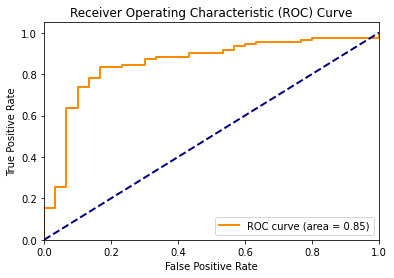

In [44]:
from sklearn.metrics import roc_curve, auc

# Load the trained model
model = keras.models.load_model('wpw_model.h5')

# Get predicted probabilities for the validation set
y_pred_prob = model.predict(X_val)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()